Marked 5 local outliers out of 248 measurements (2.0%)
Flagged 1 wells with poor logistic fit (R² < 0.5)
Total excluded (any flag): 13 of 248 (5.2%)


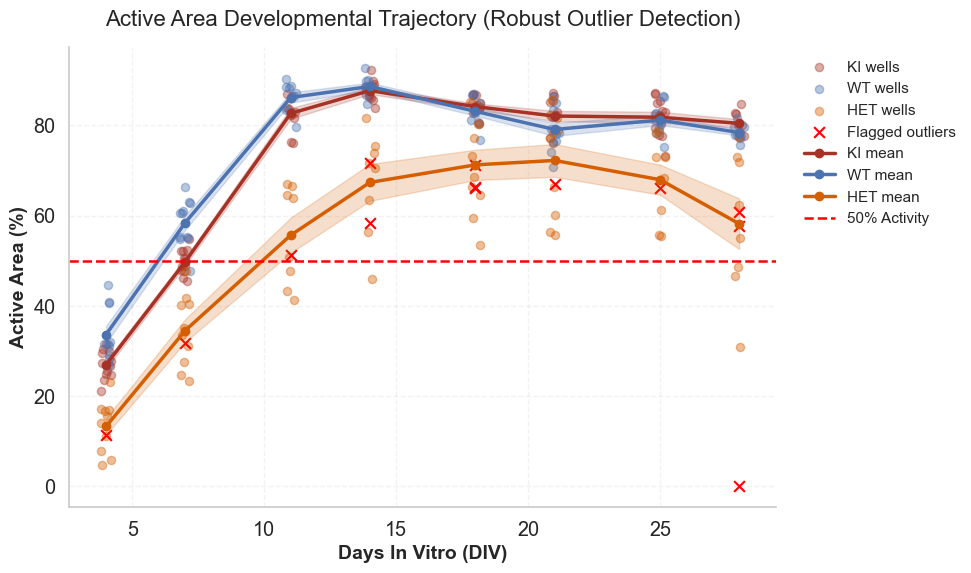

=== DIV-wise Outliers ===
    NeuronType  DIV CHIP_WELL  Active_area
97          WT   14  M05506_4    71.613636
123         KI   18  M05506_2    71.295455
125         WT   18  M05506_4    66.295455
223         WT   28  M05506_4    57.609848
234         KI   28  M07427_5    60.856061
=== Wells with Abnormal Growth (R² < 0.5) ===
  NeuronType CHIP_WELL
1        HET  M05506_3


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import warnings
warnings.filterwarnings('ignore')

# =====================================
# 1️⃣ DATA LOADING
# =====================================
def load_mea_data(csv_path):
    df = pd.read_csv(csv_path)
    df['DIV'] = df['DIV'].astype(int)
    df['Chip_ID'] = df['Chip_ID'].astype(str)
    df['Well'] = df['Well'].astype(str)
    df['NeuronType'] = df['NeuronType'].astype(str)
    df['Active_area'] = pd.to_numeric(df['Active_area'], errors='coerce')
    df['CHIP_WELL'] = df['Chip_ID'] + '_' + df['Well']
    df.dropna(subset=['Active_area'], inplace=True)
    return df


# =====================================
# 2️⃣ PER-DIV × GENOTYPE OUTLIER DETECTION
# =====================================
def detect_outliers_within_groups(df, value_col='Active_area', z_thresh=3.0):
    df = df.copy()
    df['is_outlier'] = False

    grouped = df.groupby(['NeuronType', 'DIV'])
    for (nt, div), group in grouped:
        vals = group[value_col].dropna()
        if len(vals) < 5:
            continue

        # Robust median-based Z
        median = np.median(vals)
        mad = np.median(np.abs(vals - median))
        mod_z = 0.6745 * (vals - median) / mad if mad != 0 else np.zeros_like(vals)
        outlier_mask = np.abs(mod_z) > 3.5
        df.loc[group.index[outlier_mask], 'is_outlier'] = True

    print(f"Marked {df['is_outlier'].sum()} local outliers out of {len(df)} measurements ({df['is_outlier'].mean()*100:.1f}%)")
    return df


# =====================================
# 3️⃣ LOGISTIC DEVELOPMENTAL FIT TO IDENTIFY ABNORMAL WELLS
# =====================================
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def fit_logistic_growth(well_data):
    try:
        x = well_data['DIV'].values
        y = well_data['Active_area'].values
        p0 = [np.max(y), 0.5, np.median(x)]
        params, _ = optimize.curve_fit(logistic, x, y, p0=p0, maxfev=5000)
        y_pred = logistic(x, *params)
        r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
        return params, r2
    except Exception:
        return None, np.nan

def detect_abnormal_growth(df, r2_threshold=0.5):
    df = df.copy()
    abnormal_wells = []
    for well in df['CHIP_WELL'].unique():
        well_data = df[df['CHIP_WELL'] == well].sort_values('DIV')
        if len(well_data) < 4:
            continue
        params, r2 = fit_logistic_growth(well_data)
        if np.isnan(r2) or r2 < r2_threshold:
            abnormal_wells.append(well)
    df['is_abnormal_growth'] = df['CHIP_WELL'].isin(abnormal_wells)
    print(f"Flagged {len(abnormal_wells)} wells with poor logistic fit (R² < {r2_threshold})")
    return df


# =====================================
# 4️⃣ COMBINE FLAGS INTO FILTERED VIEW
# =====================================
def mark_filtered(df):
    df['to_exclude'] = df['is_outlier'] | df['is_abnormal_growth']
    print(f"Total excluded (any flag): {df['to_exclude'].sum()} of {len(df)} ({df['to_exclude'].mean()*100:.1f}%)")
    return df


# =====================================
# 5️⃣ PLOTTING FUNCTION
# =====================================
def plot_active_area_trajectory(df, title="Developmental Trajectory of Active Area", save_path=None):
    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    palette = {'WT': '#4C72B0', 'HET': '#D55E00', 'KI': '#A63226',
               'MxWT': '#4C72B0', 'FxHET': '#D55E00', 'MxHEMI': '#A63226'}

    valid_df = df[~df['to_exclude']]
    excluded_df = df[df['to_exclude']]

    # Plot raw points (non-excluded)
    for nt in valid_df['NeuronType'].unique():
        sub = valid_df[valid_df['NeuronType'] == nt]
        jitter = (np.random.rand(len(sub)) - 0.5) * 0.4
        ax.scatter(sub['DIV'] + jitter, sub['Active_area'],
                   color=palette.get(nt, 'gray'), alpha=0.4, s=35,
                   label=f"{nt} wells")

    # Excluded points
    ax.scatter(excluded_df['DIV'], excluded_df['Active_area'],
               color='red', marker='x', s=60, label='Flagged outliers')

    # Mean ± SEM trajectories
    for nt in valid_df['NeuronType'].unique():
        stats_df = valid_df[valid_df['NeuronType'] == nt].groupby('DIV')['Active_area'].agg(['mean', 'sem'])
        divs = stats_df.index.values
        means = stats_df['mean'].values
        sems = stats_df['sem'].values
        ax.plot(divs, means, '-o', lw=2.5, color=palette.get(nt, 'black'), label=f"{nt} mean")
        ax.fill_between(divs, means - sems, means + sems, color=palette.get(nt, 'black'), alpha=0.2)

    ax.axhline(y=50, color='red', linestyle='--', linewidth=1.8, label='50% Activity')
    ax.set_xlabel('Days In Vitro (DIV)', fontsize=14, weight='bold')
    ax.set_ylabel('Active Area (%)', fontsize=14, weight='bold')
    ax.set_title(title, fontsize=16, pad=15)
    ax.legend(frameon=False, fontsize=11, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.grid(alpha=0.25, linestyle='--')
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='svg')
    plt.show()


# =====================================
# 6️⃣ PIPELINE
# =====================================
if __name__ == "__main__":
    csv_path = "/Users/mandarmp/Documents/CDKL5Paper/Fig6_dataCrunching/CDKL5_R59X_T1/ActivityScan_outputs/Compiled_Activity_Summary_cleaned.csv"

    df = load_mea_data(csv_path)
    df = detect_outliers_within_groups(df)
    df = detect_abnormal_growth(df)
    df = mark_filtered(df)

    plot_active_area_trajectory(df,
        title="Active Area Developmental Trajectory (Robust Outlier Detection)",
        save_path="/Users/mandarmp/Documents/CDKL5Paper/Fig6_dataCrunching/CDKL5_R59X_T1/ActivityScan_outputs/ActiveArea_Trajectory_Robust.svg"
    )


# List per-DIV outliers
outlier_summary = df[df['is_outlier']][['NeuronType','DIV','CHIP_WELL','Active_area']]
print("=== DIV-wise Outliers ===")
print(outlier_summary.head(20))

# List poor logistic fits
bad_growth = df[df['is_abnormal_growth']][['NeuronType','CHIP_WELL']].drop_duplicates()
print("=== Wells with Abnormal Growth (R² < 0.5) ===")
print(bad_growth)

# Save flagged list
df[df['to_exclude']][['NeuronType','CHIP_WELL','DIV','Active_area']].to_csv("flagged_wells.csv", index=False)

Marked 5 MAD-based outliers out of 248 (2.0%)
Flagged 1 wells with poor logistic fit (R² < 0.5)
Total excluded (any flag): 13 of 248 (5.2%)


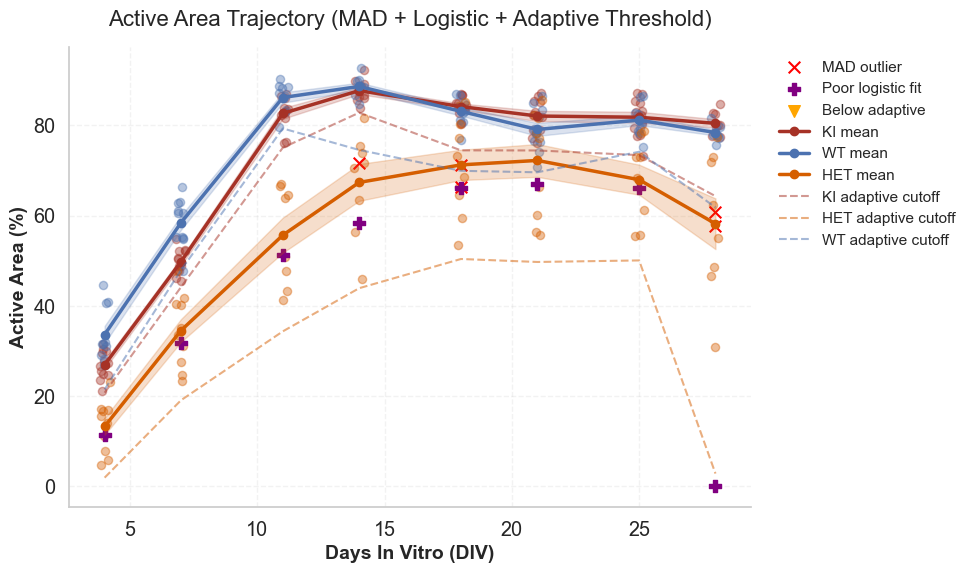


=== DIV-wise MAD Outliers ===
    NeuronType  DIV CHIP_WELL  Active_area
97          WT   14  M05506_4    71.613636
123         KI   18  M05506_2    71.295455
125         WT   18  M05506_4    66.295455
223         WT   28  M05506_4    57.609848
234         KI   28  M07427_5    60.856061

=== Wells with Abnormal Growth (R² < 0.5) ===
  NeuronType CHIP_WELL
1        HET  M05506_3

=== Wells Below Adaptive Threshold ===
Empty DataFrame
Columns: [NeuronType, DIV, CHIP_WELL, Active_area]
Index: []


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize
import warnings
warnings.filterwarnings('ignore')

# =====================================
# 1️⃣ DATA LOADING
# =====================================
def load_mea_data(csv_path):
    df = pd.read_csv(csv_path)
    df['DIV'] = df['DIV'].astype(int)
    df['Chip_ID'] = df['Chip_ID'].astype(str)
    df['Well'] = df['Well'].astype(str)
    df['NeuronType'] = df['NeuronType'].astype(str)
    df['Active_area'] = pd.to_numeric(df['Active_area'], errors='coerce')
    df['CHIP_WELL'] = df['Chip_ID'] + '_' + df['Well']
    df.dropna(subset=['Active_area'], inplace=True)
    return df


# =====================================
# 2️⃣ PER-DIV × GENOTYPE OUTLIER DETECTION (MAD-based)
# =====================================
def detect_outliers_within_groups(df, value_col='Active_area', z_thresh=3.5):
    df = df.copy()
    df['is_outlier'] = False
    grouped = df.groupby(['NeuronType', 'DIV'])
    for (nt, div), group in grouped:
        vals = group[value_col].dropna()
        if len(vals) < 5:
            continue
        median = np.median(vals)
        mad = np.median(np.abs(vals - median))
        if mad == 0:
            continue
        mod_z = 0.6745 * (vals - median) / mad
        outlier_mask = np.abs(mod_z) > z_thresh
        df.loc[group.index[outlier_mask], 'is_outlier'] = True
    print(f"Marked {df['is_outlier'].sum()} MAD-based outliers out of {len(df)} ({df['is_outlier'].mean()*100:.1f}%)")
    return df


# =====================================
# 3️⃣ LOGISTIC DEVELOPMENTAL FIT SCREEN (R²-based)
# =====================================
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def fit_logistic_growth(well_data):
    try:
        x = well_data['DIV'].values
        y = well_data['Active_area'].values
        p0 = [np.max(y), 0.5, np.median(x)]
        params, _ = optimize.curve_fit(logistic, x, y, p0=p0, maxfev=5000)
        y_pred = logistic(x, *params)
        r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
        return params, r2
    except Exception:
        return None, np.nan

def detect_abnormal_growth(df, r2_threshold=0.5):
    df = df.copy()
    abnormal_wells = []
    for well in df['CHIP_WELL'].unique():
        well_data = df[df['CHIP_WELL'] == well].sort_values('DIV')
        if len(well_data) < 4:
            continue
        params, r2 = fit_logistic_growth(well_data)
        if np.isnan(r2) or r2 < r2_threshold:
            abnormal_wells.append(well)
    df['is_abnormal_growth'] = df['CHIP_WELL'].isin(abnormal_wells)
    print(f"Flagged {len(abnormal_wells)} wells with poor logistic fit (R² < {r2_threshold})")
    return df


# =====================================
# 4️⃣ Adaptive Activity Threshold (mean - 2×std per DIV×NeuronType)
# =====================================
def flag_adaptive_threshold(df, apply_flag=True, z_thresh=2.0):
    """
    Compute and optionally flag adaptive activity threshold based on group mean − z * std.

    Parameters:
    - df: pandas DataFrame with at least ['NeuronType', 'DIV', 'Active_area']
    - apply_flag: If True, add a 'below_adaptive_threshold' boolean column.
    - z_thresh: Z-value to use for adaptive threshold (default = 2.0)
    """
    df = df.copy()
    group_stats = df.groupby(['NeuronType', 'DIV'])['Active_area'].agg(['mean', 'std']).reset_index()
    group_stats.rename(columns={'mean': 'mean_active_area', 'std': 'std_active_area'}, inplace=True)
    group_stats['adaptive_threshold'] = group_stats['mean_active_area'] - z_thresh * group_stats['std_active_area']
    df = df.merge(group_stats, on=['NeuronType', 'DIV'], how='left')

    # Only add flag if requested
    if apply_flag:
        df['below_adaptive_threshold'] = df['Active_area'] < df['adaptive_threshold']
        print(f"Flagged {df['below_adaptive_threshold'].sum()} wells below adaptive threshold (mean − {z_thresh}×std)")
    else:
        # Ensure downstream code runs safely
        df['below_adaptive_threshold'] = False
    return df


# =====================================
# 5️⃣ COMBINE FLAGS INTO FILTERED VIEW (robust)
# =====================================
def mark_filtered(df):
    # Safety: ensure required flag columns exist
    for col in ['is_outlier', 'is_abnormal_growth', 'below_adaptive_threshold']:
        if col not in df.columns:
            df[col] = False

    df['to_exclude'] = (
        df['is_outlier'] |
        df['is_abnormal_growth'] |
        df['below_adaptive_threshold']
    )
    print(f"Total excluded (any flag): {df['to_exclude'].sum()} of {len(df)} "
          f"({df['to_exclude'].mean()*100:.1f}%)")
    return df


# =====================================
# 6️⃣ PLOTTING FUNCTION
# =====================================
def plot_active_area_trajectory(df, title="Active Area Trajectory (MAD + Logistic + Adaptive)", save_path=None):
    # Safety: ensure optional columns exist
    if 'below_adaptive_threshold' not in df.columns:
        df['below_adaptive_threshold'] = False

    sns.set_theme(style='whitegrid', font_scale=1.3)
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    palette = {'WT': '#4C72B0', 'HET': '#D55E00', 'KI': '#A63226',
               'MxWT': '#4C72B0', 'FxHET': '#D55E00', 'MxHEMI': '#A63226'}

    valid_df = df[~df['to_exclude']]
    mad_out = df[df['is_outlier']]
    poor_fit = df[df['is_abnormal_growth'] & ~df['is_outlier']]
    below_adaptive = df[df['below_adaptive_threshold'] & ~df['is_outlier'] & ~df['is_abnormal_growth']]

    # Plot all valid points
    for nt in valid_df['NeuronType'].unique():
        sub = valid_df[valid_df['NeuronType'] == nt]
        jitter = (np.random.rand(len(sub)) - 0.5) * 0.4
        ax.scatter(sub['DIV'] + jitter, sub['Active_area'],
                   color=palette.get(nt, 'gray'), alpha=0.4, s=35)

    # Highlight flagged points
    ax.scatter(mad_out['DIV'], mad_out['Active_area'], color='red', marker='x', s=70, label='MAD outlier')
    ax.scatter(poor_fit['DIV'], poor_fit['Active_area'], color='purple', marker='P', s=80, label='Poor logistic fit')
    ax.scatter(below_adaptive['DIV'], below_adaptive['Active_area'], color='orange', marker='v', s=70, label='Below adaptive')

    # Mean ± SEM curves
    for nt in valid_df['NeuronType'].unique():
        stats_df = valid_df[valid_df['NeuronType'] == nt].groupby('DIV')['Active_area'].agg(['mean', 'sem'])
        divs = stats_df.index.values
        means = stats_df['mean'].values
        sems = stats_df['sem'].values
        ax.plot(divs, means, '-o', lw=2.5, color=palette.get(nt, 'black'), label=f"{nt} mean")
        ax.fill_between(divs, means - sems, means + sems, color=palette.get(nt, 'black'), alpha=0.2)

    # Adaptive threshold lines
    # Adaptive threshold lines (only if valid)
    if 'adaptive_threshold' in df.columns and df['adaptive_threshold'].notna().any():
        for nt in df['NeuronType'].unique():
            sub = df[df['NeuronType'] == nt]
            if sub['adaptive_threshold'].notna().any():
                cutoff_df = sub.groupby('DIV').agg({'adaptive_threshold': 'mean'}).reset_index()
                ax.plot(cutoff_df['DIV'], cutoff_df['adaptive_threshold'],
                        linestyle='--', color=palette.get(nt, 'black'), alpha=0.5, label=f"{nt} adaptive cutoff")

    ax.set_xlabel('Days In Vitro (DIV)', fontsize=14, weight='bold')
    ax.set_ylabel('Active Area (%)', fontsize=14, weight='bold')
    ax.set_title(title, fontsize=16, pad=15)
    ax.legend(frameon=False, fontsize=11, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax.grid(alpha=0.25, linestyle='--')
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', format='svg')
    plt.show()


# =====================================
# 7️⃣ MAIN PIPELINE
# =====================================
if __name__ == "__main__":
    csv_path = "/Users/mandarmp/Documents/CDKL5Paper/Fig6_dataCrunching/CDKL5_R59X_T1/ActivityScan_outputs/Compiled_Activity_Summary_cleaned.csv"

    df = load_mea_data(csv_path)
    df = detect_outliers_within_groups(df)
    df = detect_abnormal_growth(df)
    df = flag_adaptive_threshold(df, apply_flag=False)   # <- can toggle True/False safely
    df = mark_filtered(df)

    plot_active_area_trajectory(
        df,
        title="Active Area Trajectory (MAD + Logistic + Adaptive Threshold)",
        save_path="/Users/mandarmp/Documents/CDKL5Paper/Fig6_dataCrunching/CDKL5_R59X_T1/ActivityScan_outputs/ActiveArea_Trajectory_Adaptive.svg"
    )

    # === Summaries ===
    print("\n=== DIV-wise MAD Outliers ===")
    print(df[df['is_outlier']][['NeuronType','DIV','CHIP_WELL','Active_area']].head(20))

    print("\n=== Wells with Abnormal Growth (R² < 0.5) ===")
    print(df[df['is_abnormal_growth']][['NeuronType','CHIP_WELL']].drop_duplicates())

    print("\n=== Wells Below Adaptive Threshold ===")
    print(df[df['below_adaptive_threshold']][['NeuronType','DIV','CHIP_WELL','Active_area']].head(20))

    # === Export flagged wells ===
    df[df['to_exclude']][[
        'NeuronType','CHIP_WELL','DIV','Active_area',
        'is_outlier','is_abnormal_growth','below_adaptive_threshold'
    ]].to_csv("flagged_wells.csv", index=False)

    # Save full dataframe
    df.to_csv("full_activity_data_with_flags.csv", index=False)

Loading MEA data...
Dataset shape: (168, 16)
Genotypes (NeuronTypes): ['MxWT' 'FxHET']
DIV range: 7 - 31
Number of wells: 28
['M07305_1' 'M07305_2' 'M07305_3' 'M07305_4' 'M07305_5' 'M07305_6'
 'M08020_1' 'M08020_2' 'M08020_3' 'M08020_4' 'M08020_5' 'M08020_6'
 'M08024_1' 'M08024_4' 'M08024_5' 'M08024_6' 'M08029_1' 'M08029_2'
 'M08029_3' 'M08029_4' 'M08029_5' 'M08029_6' 'M08034_1' 'M08034_2'
 'M08034_3' 'M08034_4' 'M08034_5' 'M08034_6']
Wells failing threshold of 50 before DIV 27:
 - M08020_6
 - M08029_1
 - M08029_2
 - M08029_3
 - M08034_1
 - M08034_2
 - M08034_3
Remaining wells after threshold filter: 21
No wells have declining activity (slope < 0) before DIV 27.

Calculating trajectory metrics...
Detecting outliers...

=== ANALYSIS SUMMARY ===
Total outliers detected (overall Z-score): 2
Total outliers detected (overall IQR): 3
MxWT outliers: 0/42 (0.0%)
FxHET outliers: 3/84 (3.6%)


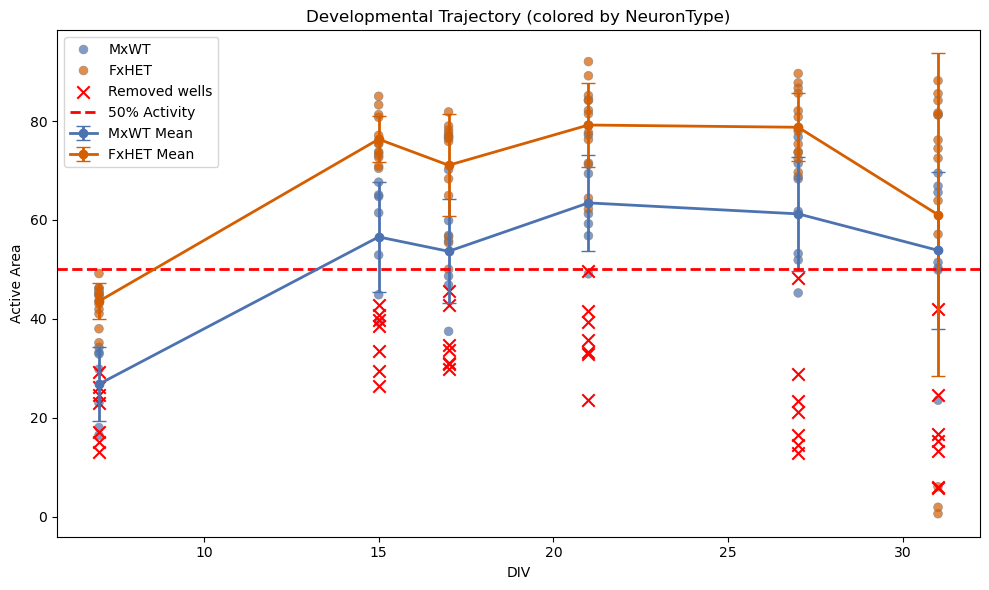

In [25]:
if __name__ == "__main__":
    csv_path = "/Users/mandarmp/Documents/CDKL5Paper/Fig2/Compiled_Activity_Summary_cleaned_E6Dt2.csv"  # Replace with path to your file
    results = run_complete_mea_analysis(csv_path)
    df_outliers, trajectory_df, outlier_results, traj_outliers, summary ,df_removed= results
    hue_column = 'NeuronType'  # Use 'CHIP_WELL', 'Well', etc. for alternative coloring

    # Custom palette for NeuronType colors
    palette = {
    'MxWT': '#4C72B0',    # Steel Blue - Good
    'FxHET': '#D55E00',   # Burnt Orange - Severe
    'MxHEMI': '#A63226',  # Dark Red - Very Severe
    }

    plt.figure(figsize=(10, 6))

    # Plot all individual points colored by chosen hue
    sns.scatterplot(
        x='DIV',
        y='Active_area',
        hue=hue_column,
        data=df_outliers,
        palette=palette if hue_column == 'NeuronType' else None,
        s=40,
        alpha=0.7,
        edgecolor='grey'
    )

       # Make sure df_removed is defined here as well
    if 'df_removed' in locals() and not df_removed.empty:
        plt.scatter(
            df_removed['DIV'], df_removed['Active_area'],
            color='red', marker='x', s=80, label='Removed wells'
        )
    else:
        print("No wells were removed during filtering.")

    for genotype in df_outliers['NeuronType'].unique():
        genotype_data = df_outliers[df_outliers['NeuronType'] == genotype]
        div_means = genotype_data.groupby('DIV')['Active_area'].mean()
        div_stds = genotype_data.groupby('DIV')['Active_area'].std()
        plt.errorbar(div_means.index, div_means.values, yerr=div_stds.values,
                     label=f'{genotype} Mean', marker='o', capsize=5, linewidth=2, color=palette.get(genotype, None))

    plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% Activity')
    plt.xlabel('DIV')
    plt.ylabel('Active Area')
    plt.title(f'Developmental Trajectory (colored by {hue_column})')
    plt.legend()
    plt.tight_layout()
    plt.savefig('mea_activity_points_and_trajectory.png', dpi=300, bbox_inches='tight')
    plt.show()

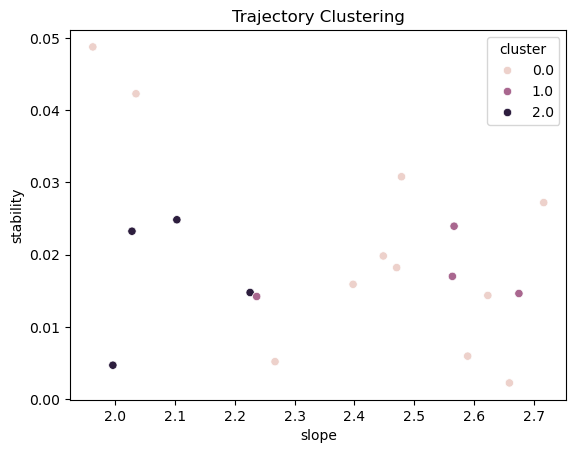

In [2]:
from sklearn.cluster import KMeans
metrics_df = trajectory_df[['slope', 'stability', 'activity_range']].dropna()
kmeans = KMeans(n_clusters=3, random_state=42).fit(metrics_df)
trajectory_df.loc[metrics_df.index, 'cluster'] = kmeans.labels_

sns.scatterplot(x='slope', y='stability', hue='cluster', data=trajectory_df)
plt.title('Trajectory Clustering')
plt.show()


**Final function**

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
def load_mea_data(csv_path):
    df = pd.read_csv(csv_path)
    df['DIV'] = df['DIV'].astype(int)
    df['Chip_ID'] = df['Chip_ID'].astype(str)
    df['Well'] = df['Well'].astype(str)
    df['NeuronType'] = df['NeuronType'].astype(str)
    df['Active_area'] = pd.to_numeric(df['Active_area'], errors='coerce')
    df['CHIP_WELL'] = df['Chip_ID'] + '_' + df['Well']
    df['DIV_Genotype'] = df['DIV'].astype(str) + '_' + df['NeuronType']
    return df

def filter_wells_by_threshold(df, threshold=50, max_div=27):
    df_early = df[df['DIV'] < max_div].copy()
    well_max = df_early.groupby('CHIP_WELL')['Active_area'].max()
    wells_fail = well_max[well_max < threshold].index.to_list()
    
    if len(wells_fail) == 0:
        print(f"No wells failed the threshold of {threshold} before DIV {max_div}.")
        df_removed = df.iloc[0:0].copy()  # empty DataFrame with columns
        df_filtered = df.copy()
    else:
        print(f"Wells failing threshold of {threshold} before DIV {max_div}:")
        for w in wells_fail:
            print(f" - {w}")
        df_filtered = df[~df['CHIP_WELL'].isin(wells_fail)].copy()
        df_removed = df[df['CHIP_WELL'].isin(wells_fail)].copy()
        print(f"Remaining wells after threshold filter: {df_filtered['CHIP_WELL'].nunique()}")
    return df_filtered, df_removed

def filter_wells_by_decline(df, max_div=30, decline_threshold=0):
    wells_to_remove = []
    for well in df['CHIP_WELL'].unique():
        well_data = df[(df['CHIP_WELL'] == well) & (df['DIV'] < max_div)].sort_values('DIV')
        if len(well_data) >= 3:
            divs = well_data['DIV'].values
            activities = well_data['Active_area'].values
            slope, _, _, _, _ = stats.linregress(divs, activities)
            if slope < decline_threshold:
                wells_to_remove.append(well)
    if len(wells_to_remove) == 0:
        print(f"No wells have declining activity (slope < {decline_threshold}) before DIV {max_div}.")
        df_removed = df.iloc[0:0].copy()  # empty DataFrame with columns
        df_filtered = df.copy()
    else:
        print(f"Wells with declining activity (slope < {decline_threshold}) before DIV {max_div}:")
        for w in wells_to_remove:
            print(f" - {w}")
        df_filtered = df[~df['CHIP_WELL'].isin(wells_to_remove)].copy()
        df_removed = df[df['CHIP_WELL'].isin(wells_to_remove)].copy()
        print(f"Remaining wells after decline filter: {df_filtered['CHIP_WELL'].nunique()}")
    return df_filtered, df_removed

def calculate_trajectory_metrics(df):
    trajectory_metrics = []
    for genotype in df['NeuronType'].unique():
        for chip_well in df[df['NeuronType'] == genotype]['CHIP_WELL'].unique():
            well_data = df[(df['NeuronType'] == genotype) & (df['CHIP_WELL'] == chip_well)].sort_values('DIV')
            if len(well_data) >= 3:
                divs = well_data['DIV'].values
                activities = well_data['Active_area'].values
                valid_mask = ~np.isnan(activities)
                if np.sum(valid_mask) >= 3:
                    divs_clean = divs[valid_mask]
                    activities_clean = activities[valid_mask]
                    slope, intercept, r_value, p_value, std_err = stats.linregress(divs_clean, activities_clean)
                    max_activity = np.max(activities_clean)
                    min_activity = np.min(activities_clean)
                    activity_range = max_activity - min_activity
                    final_activity = activities_clean[-1] if len(activities_clean) > 0 else np.nan
                    initial_activity = activities_clean[0] if len(activities_clean) > 0 else np.nan
                    dev_rate = slope
                    if len(activities_clean) >= 4:
                        late_activities = activities_clean[-3:]
                        stability = np.std(late_activities) / np.mean(late_activities) if np.mean(late_activities) > 0 else np.nan
                    else:
                        stability = np.nan
                    trajectory_metrics.append({
                        'NeuronType': genotype,
                        'CHIP_WELL': chip_well,
                        'slope': slope,
                        'r_squared': r_value**2,
                        'p_value': p_value,
                        'max_activity': max_activity,
                        'min_activity': min_activity,
                        'activity_range': activity_range,
                        'final_activity': final_activity,
                        'initial_activity': initial_activity,
                        'dev_rate': dev_rate,
                        'stability': stability,
                        'n_timepoints': len(activities_clean)
                    })
    return pd.DataFrame(trajectory_metrics)

def detect_outliers_multiple_methods(data, methods=['zscore', 'iqr', 'modified_zscore']):
    outliers = {}
    if 'zscore' in methods:
        z_scores = np.abs(zscore(data, nan_policy='omit'))
        outliers['zscore'] = z_scores > 3
    if 'iqr' in methods:
        Q1 = np.nanpercentile(data, 25)
        Q3 = np.nanpercentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers['iqr'] = (data < lower_bound) | (data > upper_bound)
    if 'modified_zscore' in methods:
        median = np.nanmedian(data)
        mad = np.nanmedian(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad if mad != 0 else np.zeros_like(data)
        outliers['modified_zscore'] = np.abs(modified_z_scores) > 3.5
    return outliers

def analyze_outliers_by_genotype(df):
    results = {'overall_outliers': [], 'genotype_outliers': {}, 'trajectory_outliers': [], 'summary_stats': {}}
    overall_data = df['Active_area'].dropna()
    overall_outliers = detect_outliers_multiple_methods(overall_data)
    df_with_outliers = df.copy()
    for method, outlier_mask in overall_outliers.items():
        df_with_outliers[f'outlier_{method}'] = False
        valid_indices = df['Active_area'].dropna().index
        df_with_outliers.loc[valid_indices, f'outlier_{method}'] = outlier_mask
    for genotype in df['NeuronType'].unique():
        genotype_data = df[df['NeuronType'] == genotype]['Active_area'].dropna()
        if len(genotype_data) > 5:
            genotype_outliers = detect_outliers_multiple_methods(genotype_data)
            results['genotype_outliers'][genotype] = genotype_outliers
            for method, outlier_mask in genotype_outliers.items():
                col_name = f'outlier_{genotype}_{method}'
                df_with_outliers[col_name] = False
                valid_indices = df[df['NeuronType'] == genotype]['Active_area'].dropna().index
                df_with_outliers.loc[valid_indices, col_name] = outlier_mask
    for div in df['DIV'].unique():
        div_data = df[df['DIV'] == div]['Active_area'].dropna()
        if len(div_data) > 3:
            div_outliers = detect_outliers_multiple_methods(div_data)
            for method, outlier_mask in div_outliers.items():
                col_name = f'outlier_DIV{div}_{method}'
                df_with_outliers[col_name] = False
                valid_indices = df[df['DIV'] == div]['Active_area'].dropna().index
                df_with_outliers.loc[valid_indices, col_name] = outlier_mask
    return df_with_outliers, results

def analyze_trajectory_outliers(trajectory_df):
    trajectory_outliers = {}
    metrics_to_analyze = ['slope', 'r_squared', 'max_activity', 'activity_range', 'dev_rate', 'stability', 'final_activity']
    for metric in metrics_to_analyze:
        if metric in trajectory_df.columns:
            data = trajectory_df[metric].dropna()
            if len(data) > 3:
                outliers = detect_outliers_multiple_methods(data)
                trajectory_outliers[metric] = outliers
    return trajectory_outliers


def run_complete_mea_analysis(csv_path, output_prefix='mea_analysis',
                              threshold=50, max_div=27, decline_threshold=0):
    print("Loading MEA data...")
    df = load_mea_data(csv_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Genotypes (NeuronTypes): {df['NeuronType'].unique()}")
    print(f"DIV range: {df['DIV'].min()} - {df['DIV'].max()}")
    print(f"Number of wells: {df['CHIP_WELL'].nunique()}")
    print(df['CHIP_WELL'].unique())

    df_filtered, df_removed_threshold = filter_wells_by_threshold(df, threshold=threshold, max_div=max_div)
    df_filtered, df_removed_decline = filter_wells_by_decline(df_filtered, max_div=max_div, decline_threshold=decline_threshold)
    
    # Combine all removed wells for marking
    df_removed = pd.concat([df_removed_threshold, df_removed_decline]).drop_duplicates()

    print("\nCalculating trajectory metrics...")
    trajectory_df = calculate_trajectory_metrics(df_filtered)
    print("Detecting outliers...")
    df_with_outliers, outlier_results = analyze_outliers_by_genotype(df_filtered)
    trajectory_outliers = analyze_trajectory_outliers(trajectory_df)

    summary_stats = {}
    for genotype in df_filtered['NeuronType'].unique():
        genotype_data = df_filtered[df_filtered['NeuronType'] == genotype]
        summary_stats[genotype] = {
            'n_wells': genotype_data['CHIP_WELL'].nunique(),
            'n_measurements': len(genotype_data),
            'mean_activity': genotype_data['Active_area'].mean(),
            'std_activity': genotype_data['Active_area'].std(),
            'cv_activity': (genotype_data['Active_area'].std() / genotype_data['Active_area'].mean()) * 100
        }

    df_with_outliers.to_csv(f'{output_prefix}_data_with_outliers.csv', index=False)
    trajectory_df.to_csv(f'{output_prefix}_trajectory_metrics.csv', index=False)

    print(f"\n=== ANALYSIS SUMMARY ===")
    print(f"Total outliers detected (overall Z-score): {df_with_outliers['outlier_zscore'].sum()}")
    print(f"Total outliers detected (overall IQR): {df_with_outliers['outlier_iqr'].sum()}")
    for genotype in df_filtered['NeuronType'].unique():
        if f'outlier_{genotype}_zscore' in df_with_outliers.columns:
            n_outliers = df_with_outliers[f'outlier_{genotype}_zscore'].sum()
            n_total = len(df_with_outliers[df_with_outliers['NeuronType'] == genotype])
            print(f"{genotype} outliers: {n_outliers}/{n_total} ({n_outliers/n_total*100:.1f}%)")
    return df_with_outliers, trajectory_df, outlier_results, trajectory_outliers, summary_stats, df_removed

if __name__ == "__main__":
    csv_path = "/Users/mandarmp/Documents/CDKL5Paper/Fig6_dataCrunching/CDKL5_R59X_T1/ActivityScan_outputs/Compiled_Activity_Summary_cleaned.csv"
    results = run_complete_mea_analysis(csv_path, threshold=50, max_div=27, decline_threshold=0)
    df_outliers, trajectory_df, outlier_results, traj_outliers, summary,df_removed = results

    hue_column = 'NeuronType'
    palette = {
        'MxWT': '#4C72B0',
        'FxHET': '#D55E00',
        'MxHEMI': '#A63226',
        'WT': '#4C72B0',
        'HET': '#D55E00',
        'HEMI': '#A63226',
        'KI' :'#A63226'
    }

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='DIV',
        y='Active_area',
        hue=hue_column,
        data=df_outliers,
        palette=palette if hue_column == 'NeuronType' else None,
        s=40,
        alpha=0.7,
        edgecolor='grey'
    )
   # Make sure df_removed is defined here as well
    if 'df_removed' in locals() and not df_removed.empty:
        plt.scatter(
            df_removed['DIV'], df_removed['Active_area'],
            color='red', marker='x', s=80, label='Removed wells'
        )
    else:
        print("No wells were removed during filtering.")

    for genotype in df_outliers['NeuronType'].unique():
        genotype_data = df_outliers[df_outliers['NeuronType'] == genotype]
        div_means = genotype_data.groupby('DIV')['Active_area'].mean()
        div_stds = genotype_data.groupby('DIV')['Active_area'].std()
        plt.errorbar(div_means.index, div_means.values, yerr=div_stds.values,
                     label=f'{genotype} Mean', marker='o', capsize=5, linewidth=2, color=palette.get(genotype, None))

    plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% Activity')
    plt.xlabel('DIV')
    plt.ylabel('Active Area')
    plt.title(f'Developmental Trajectory (colored by {hue_column})')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/Users/mandarmp/Documents/CDKL5Paper/Fig6_dataCrunching/CDKL5_R59X_T1/ActivityScan_outputs/mea_activity_points_and_trajectory.png', dpi=300, bbox_inches='tight')
    plt.show()


In [4]:
# Final version, dynamic threshold and div selection
import pandas as pd
from scipy import stats

def threshold_filter(datapath,threshold,upperdiv,lowerdiv):
    data = pd.read_csv(datapath)
    data_subset = data[(data['DIV'] > lowerdiv) & (data['DIV'] < upperdiv)].copy()
    data_outliers = data_subset[data_subset['Active_area'] <= threshold]
    data_outliers_unique = data_outliers[['Chip_ID', 'Well', 'NeuronType']].drop_duplicates()
    return data_outliers_unique


# def iqr_filter(datapath,upperdiv,lowerdiv):
#     data = pd.read_csv(datapath)
#     data_subset = data[(data['DIV'] > lowerdiv) & (data['DIV'] < upperdiv)].copy()
#     Q1 = data_subset.groupby(['DIV', 'NeuronType'])['Active_area'].transform(lambda x: x.quantile(0.25))
#     Q3 = data_subset.groupby(['DIV', 'NeuronType'])['Active_area'].transform(lambda x: x.quantile(0.75))
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     data_iqr_outliers = data_subset[(data_subset['Active_area'] < lower_bound) | (data_subset['Active_area'] > upper_bound)]
#     data_iqr_outliers_unique = data_iqr_outliers[['Chip_ID', 'Well', 'NeuronType']].drop_duplicates()
#     return data_iqr_outliers_unique


def z_score_filter(datapath,upperdiv,lowerdiv):
    data = pd.read_csv(datapath)
    data_subset = data[(data['DIV'] > lowerdiv) & (data['DIV'] < upperdiv)].copy()
    data_subset['Z_score'] = data_subset.groupby(['DIV', 'NeuronType'])['Active_area'].transform(lambda x: stats.zscore(x))
    z_threshold = 2
    data_z_outliers = data_subset[(data_subset['Z_score'] > z_threshold) | (data_subset['Z_score'] < -z_threshold)]
    data_z_outliers_unique = data_z_outliers[['Chip_ID', 'Well', 'NeuronType']].drop_duplicates()
    return data_z_outliers_unique

def combine_filters(datapath,threshold,upperdiv,lowerdiv):
    outliers_threshold = threshold_filter(datapath,threshold,upperdiv,lowerdiv)
    outliers_z_score = z_score_filter(datapath,upperdiv,lowerdiv)
    combined_outliers = pd.concat([outliers_threshold,  outliers_z_score]).drop_duplicates()
    combined_outliers.sort_values(by=['Chip_ID', 'Well'], inplace=True)
    combined_outliers.reset_index(drop=True, inplace=True)
    print("Outliers identified by Threshold Filter:")
    print(outliers_threshold.sort_values(by=['Chip_ID', 'Well']).reset_index(drop=True))
    print("\nOutliers identified by Z-score Filter:")
    print(outliers_z_score.sort_values(by=['Chip_ID', 'Well']).reset_index(drop=True))
    return combined_outliers

In [2]:
# Example usage
knct4_path = "/Users/mandarmp/Documents/CDKL5Paper/Fig2/ActivityScan_outputs/Compiled_Activity_Summary.csv"
upperdiv=27
lowerdiv=5
threshold=35

In [3]:
threshold_filter(knct4_path,threshold,upperdiv,lowerdiv)

,Chip_ID,Well,NeuronType


In [14]:
z_score_filter(knct4_path,upperdiv,lowerdiv)

,Chip_ID,Well,NeuronType
48,M07299,3,HOM
85,M08034,6,HET


In [15]:
# Example usage
combine_filters(knct4_path,threshold,upperdiv,lowerdiv)

Outliers identified by Threshold Filter:
  Chip_ID  Well NeuronType
0  M07299     1        HOM
1  M07299     3        HOM

Outliers identified by Z-score Filter:
  Chip_ID  Well NeuronType
0  M07299     3        HOM
1  M08034     6        HET


,Chip_ID,Well,NeuronType
0,M07299,1,HOM
1,M07299,3,HOM
2,M08034,6,HET


_____________________________________

In [ ]:
# read in the data from the csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read in the data from the csv file
data=pd.read_csv("/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_T1_ALL/Activity/Compiled_ActivityScan.csv")

In [ ]:
# check unique chip IDs
chip_ids = data['Chip_ID'].unique()
chip_ids

array(['M06691', 'M07036', 'M07301', 'M07309'], dtype=object)

In [ ]:
# # Screening criteria
# # Criteria 1: screen CHIP_ID with Active_area consistently smaller than 35 across all 'DIV'
# grouped_data = data.groupby(['Chip_ID', 'Well'])

# # Filter out groups where all Active_area values are less than 35
# data_screen = grouped_data.filter(lambda x: all(x['Active_area'] < 35))

# # Display the filtered data
# data_screen_unique_units = data_screen.drop_duplicates(subset=['Chip_ID', 'Well'])
# data_screen_unique_units

In [ ]:
# Criteria 1: Filter out groups where any Active_area values are less than 35 after DIV 4 and DIV 7

# subset drop div 4 and div 7
data_subset = data[data['DIV'] > 7]

data_outliers = data_subset[data_subset['Active_area']<=35]

data_outliers_unique = data_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations
print(data_outliers_unique)

# export the result in csv file
# data_outliers_unique.to_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_Therapy_T1/Activity/Outliers.csv', index=False)

    Chip_ID  Well
59   M07036     6
66   M07309     1
68   M07309     3
152  M07036     3
156  M07301     1
163  M07309     2
216  M06691     1
222  M07036     1
223  M07036     2
225  M07036     4
322  M07036     5
373  M07301     2


In [ ]:
# Criteria 2: Filter out groups where any Active_area values based on IQR
data_subset = data[data['DIV'] > 7]
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data_subset['Active_area'].quantile(0.25)
Q3 = data_subset['Active_area'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Determine the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'Active_area' is an outlier
data_iqr_outliers = data_subset[(data_subset['Active_area'] < lower_bound) | (data_subset['Active_area'] > upper_bound)]

# Identify the unique combinations of Chip_ID and Well after filtering
data_iqr_outliers_unique = data_iqr_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations
print(data_iqr_outliers_unique)

Empty DataFrame
Columns: [Chip_ID, Well]
Index: []


In [ ]:
# Criteria 2 updated: Filter out groups where any Active_area values based on IQR for EACH 'DIV' group

data_subset = data[data['DIV'] > 7].copy()

# Calculate the IQR for each group
Q1 = data_subset.groupby('DIV')['Active_area'].transform(lambda x: x.quantile(0.25))
Q3 = data_subset.groupby('DIV')['Active_area'].transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1

# Determine the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'Active_area' is an outlier
data_iqr_outliers = data_subset[(data_subset['Active_area'] < lower_bound) | (data_subset['Active_area'] > upper_bound)]

# Identify the unique combinations of Chip_ID and Well after filtering
data_iqr_outliers_unique = data_iqr_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Return the unique combinations DataFrame
print(data_iqr_outliers_unique)

Empty DataFrame
Columns: [Chip_ID, Well]
Index: []


In [ ]:
# Criteria 3: Filter out groups where any Active_area values based on Z-score
from scipy import stats

# Filter the data for DIV > 7 and make a copy to avoid SettingWithCopyWarning
data_subset = data[data['DIV'] > 7].copy()

# Calculate the Z-scores for the 'Active_area' column and assign using .loc
data_subset.loc[:, 'Z_score'] = stats.zscore(data_subset['Active_area'])

# Define a threshold for identifying outliers (commonly Z > 2 or Z < -2)
z_threshold = 2

# Filter out rows where 'Active_area' is an outlier based on Z-score
data_z_outliers = data_subset[(data_subset['Z_score'] > z_threshold) | (data_subset['Z_score'] < -z_threshold)]

# Identify the unique combinations of Chip_ID and Well for the outliers
data_z_outliers_unique = data_z_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations of outliers
print(data_z_outliers_unique)

    Chip_ID  Well
170  M06691     3


In [ ]:
# Criteria 3 update: Filter out groups where any Active_area values based on Z-score for EACH DIV
from scipy import stats

# Calculate the Z-scores for 'Active_area' within each group of 'div' using .loc to avoid the SettingWithCopyWarning
data_subset.loc[:, 'Z_score'] = data_subset.groupby('DIV')['Active_area'].transform(lambda x: stats.zscore(x))

# Define a threshold for identifying outliers (commonly Z > 2 or Z < -2)
z_threshold = 2

# Filter out rows where 'Active_area' is an outlier based on Z-score within each 'div'
data_z_outliers = data_subset[(data_subset['Z_score'] > z_threshold) | (data_subset['Z_score'] < -z_threshold)]

# Identify the unique combinations of Chip_ID and Well for the outliers
data_z_outliers_unique = data_z_outliers[['Chip_ID', 'Well']].drop_duplicates()

# Display the unique combinations of outliers
print(data_z_outliers_unique)

Empty DataFrame
Columns: [Chip_ID, Well]
Index: []


In [ ]:
# Check
# Iterate over each group to print outliers per date
for div, group in data_subset.groupby('DIV'):
    group['Z_score'] = stats.zscore(group['Active_area'])
    outliers = group[(group['Z_score'] > z_threshold) | (group['Z_score'] < -z_threshold)]
    unique_outliers = outliers[['Chip_ID', 'Well']].drop_duplicates()
    
    if not unique_outliers.empty:
        print(f"Outliers for div {div}:")
        print(unique_outliers)

Outliers for div 12:
   Chip_ID  Well
59  M07036     6
Outliers for div 15:
   Chip_ID  Well
83  M07036     6
Outliers for div 19:
    Chip_ID  Well
107  M07036     6
Outliers for div 22:
    Chip_ID  Well
131  M07036     6
Outliers for div 26:
    Chip_ID  Well
155  M07036     6
164  M07309     3
Outliers for div 29:
    Chip_ID  Well
179  M07036     6


In [ ]:
# Compare results of all outlier detection methods
# Create dataframes for each criteria's results
criteria_1 = pd.DataFrame({
    'Chip_ID': ['M07036', 'M07309', 'M07309', 'M07036', 'M07301', 'M07309'],
    'Well': [6, 1, 3, 3, 1, 2]
})

criteria_2 = pd.DataFrame({
    'Chip_ID': ['M07036', 'M07309'],
    'Well': [6, 3]
})

criteria_3 = pd.DataFrame({
    'Chip_ID': ['M07036', 'M07309', 'M07036'],
    'Well': [6, 3, 3]
})

# Merge the dataframes for comparison
comparison_table = criteria_1.merge(criteria_2, on=['Chip_ID', 'Well'], how='outer', indicator='Criteria_2').merge(
    criteria_3, on=['Chip_ID', 'Well'], how='outer', indicator='Criteria_3')

# Adjust indicators for readability
comparison_table['Criteria_2'] = comparison_table['Criteria_2'].apply(lambda x: 'Yes' if x == 'both' else 'No')
comparison_table['Criteria_3'] = comparison_table['Criteria_3'].apply(lambda x: 'Yes' if x == 'both' else 'No')

# Rename columns for clarity
comparison_table = comparison_table.rename(columns={'Criteria_2': 'In Criteria 2', 'Criteria_3': 'In Criteria 3'})

# Fill in for Criteria 1 (since it was the base)
comparison_table['In Criteria 1'] = 'Yes'

# Reorder columns
comparison_table = comparison_table[['Chip_ID', 'Well', 'In Criteria 1', 'In Criteria 2', 'In Criteria 3']]
comparison_table
# export the comparison table to a CSV file at certain path
# path = '/Users/liufanling/Library/CloudStorage/OneDrive-个人/1 UC DAVIS/2024 Summer/CSRA/Outputs/SYNGAP_T1/Outlier_detection'

# comparison_table.to_csv(path+'comparison_table.csv', index=False)


,Chip_ID,Well,In Criteria 1,In Criteria 2,In Criteria 3
0,M07036,3,Yes,No,Yes
1,M07036,6,Yes,Yes,Yes
2,M07301,1,Yes,No,No
3,M07309,1,Yes,No,No
4,M07309,2,Yes,No,No
5,M07309,3,Yes,Yes,Yes


<Figure size 1400x1000 with 0 Axes>

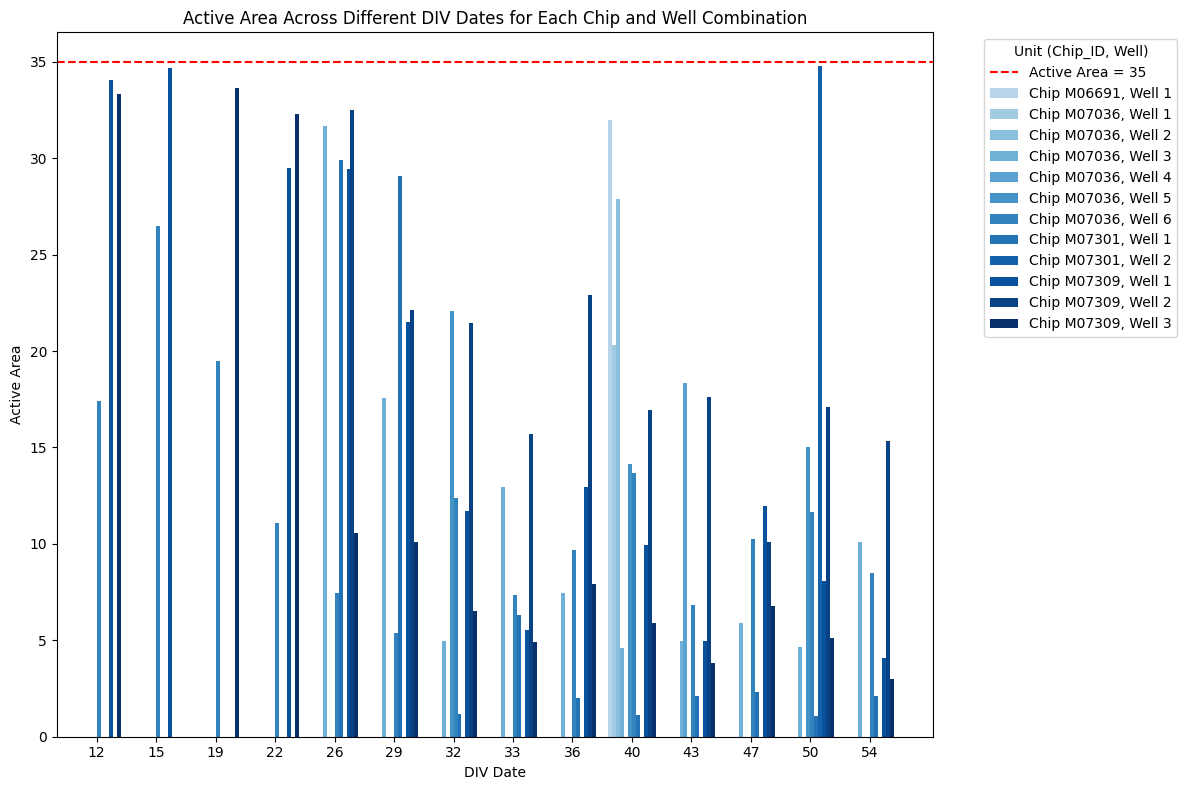

In [ ]:
# Plotting the active area across different DIV dates for each Chip and Well combination
pivot_data = data_outliers.pivot_table(index=['DIV'], columns=['Chip_ID', 'Well'], values='Active_area')
num_units = len(pivot_data.columns)
# Generating different shades of blue for each unit
colors = plt.cm.Blues(np.linspace(0.3, 1, num_units))

# Adjusting the plot to make the bars from different units at the same DIV distribute side by side in a vertical orientation
plt.figure(figsize=(14, 10))

# Re-calculating the pivot data since it seems not in scope here


# Define the number of units and calculate the width of each bar based on the number of units
num_units = len(pivot_data.columns)
total_width = 0.8  # Total space allocated for all bars at each DIV date
bar_width = total_width / num_units  # Width of each individual bar

# Plot setup
plt.figure(figsize=(12, 8))

# Plotting
for index, (column, series) in enumerate(pivot_data.items()):
    # Position each bar based on its order in the dataframe
    positions = [x - (total_width - bar_width) / 2 + index * bar_width for x in range(len(pivot_data))]
    plt.bar(positions, series.values, width=bar_width, color=colors[index], label=f'Chip {column[0]}, Well {column[1]}')

# Adding a horizontal dashed line at Active Area = 35 for reference
plt.axhline(y=35, color='r', linestyle='--', linewidth=1.5, label='Active Area = 35')

# Labeling and aesthetics
plt.xlabel('DIV Date')
plt.ylabel('Active Area')
plt.title('Active Area Across Different DIV Dates for Each Chip and Well Combination')
plt.xticks(range(len(pivot_data)), pivot_data.index)  # Set x-ticks to be the DIV dates
plt.legend(title="Unit (Chip_ID, Well)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

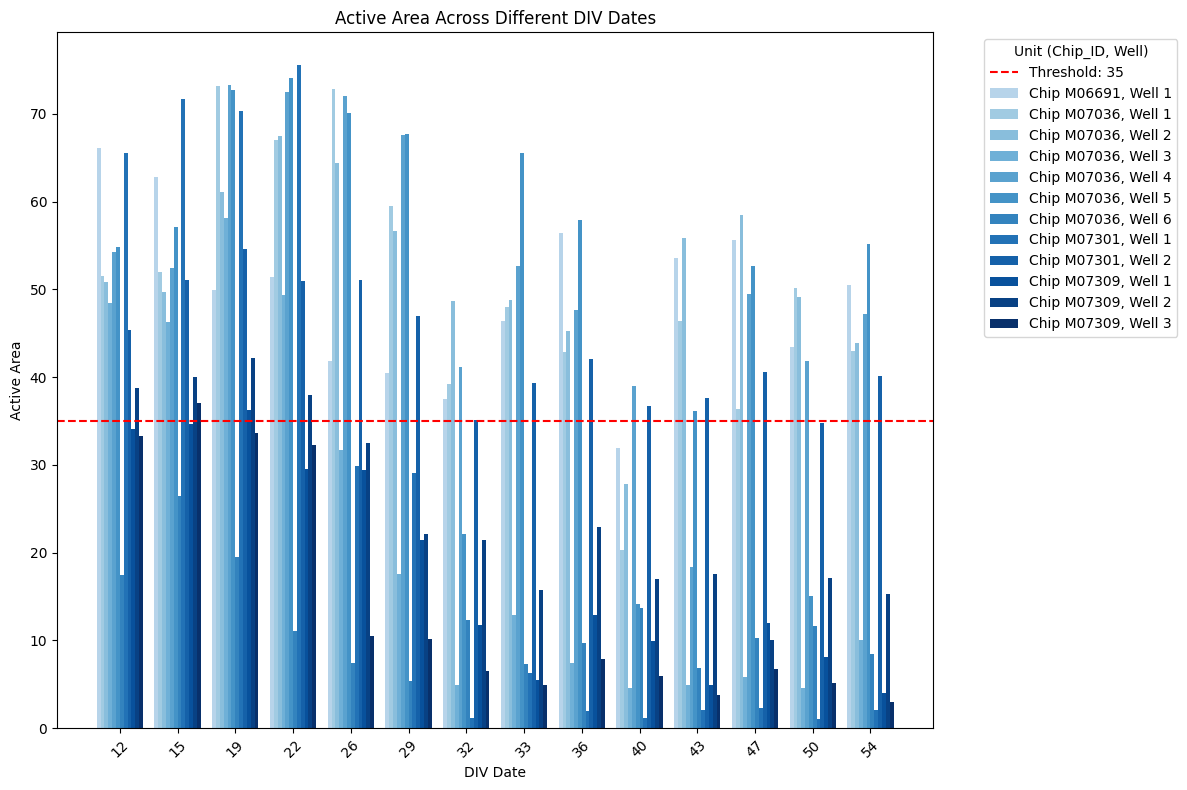

In [ ]:
# Include all DIV data for units with Active_area <= 35

units_with_low_area = data_subset[data_subset['Active_area'] <= 35][['Chip_ID', 'Well']].drop_duplicates()

# Filter the original dataset to include all DIV data for these units
filtered_data = data_subset.merge(units_with_low_area, on=['Chip_ID', 'Well'])

# Create a pivot table
pivot_data = filtered_data.pivot_table(index='DIV', columns=['Chip_ID', 'Well'], values='Active_area', aggfunc='first')

# Plot setup
num_units = len(pivot_data.columns)
colors = plt.cm.Blues(np.linspace(0.3, 1, num_units))
total_width = 0.8  # Total width for bars at each DIV date
bar_width = total_width / num_units  # Width of each bar

# Plot setup
plt.figure(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(0.3, 1, num_units))

total_width = 0.8
bar_width = total_width / len(pivot_data.columns)

# Plotting each set of bars
for i, ((chip_id, well), series) in enumerate(pivot_data.items()):
    # Offset positions for each bar group
    positions = np.arange(len(pivot_data)) - (total_width - bar_width) / 2 + i * bar_width
    plt.bar(positions, series, width=bar_width, color=colors[i], label=f'Chip {chip_id}, Well {well}')

# Adding the horizontal line and labels
plt.axhline(y=35, color='red', linestyle='--', label='Threshold: 35')
plt.xlabel('DIV Date')
plt.ylabel('Active Area')
plt.title('Active Area Across Different DIV Dates')
plt.xticks(np.arange(len(pivot_data)), pivot_data.index, rotation=45)
plt.legend(title="Unit (Chip_ID, Well)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

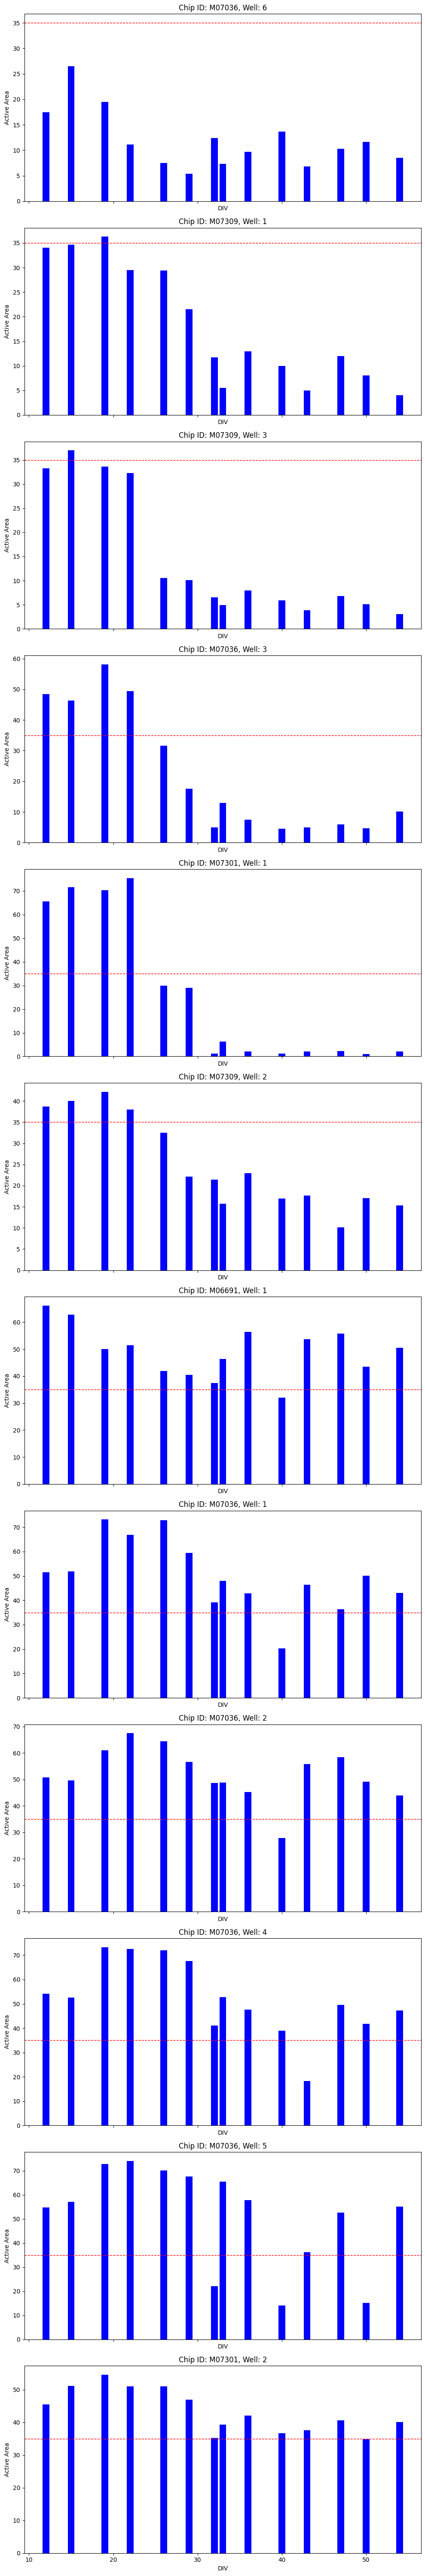

In [ ]:
# Check single unit seperately

fig, axs = plt.subplots(nrows=len(data_outliers_unique), ncols=1, figsize=(10, 5 * len(data_outliers_unique)), sharex=True)

# Ensure axs is iterable if there's only one plot
if len(data_outliers_unique) == 1:
    axs = [axs]

for ax, (idx, row) in zip(axs, data_outliers_unique.iterrows()):
    # Extract the full data for this specific unit from the original dataset
    unit_data = data_subset[(data_subset['Chip_ID'] == row['Chip_ID']) & (data_subset['Well'] == row['Well'])]
    ax.bar(unit_data['DIV'], unit_data['Active_area'], color='b')
    ax.axhline(y=35, color='r', linestyle='--', linewidth=1)
    ax.set_title(f"Chip ID: {row['Chip_ID']}, Well: {row['Well']}")
    ax.set_xlabel('DIV')
    ax.set_ylabel('Active Area')

plt.tight_layout()
plt.show()